Learning Multiple, alternating frequency outputs for a single channel
===========
Michael Nolan, 2020.06.15

In this notebook I show the behavior of 1-layer GRU seq2seq networks as they learn to predict sinusoid time series segments. These time segments have random phase and are one of n frequencies with uniform probability.

In [2]:
from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training, Encoder, Decoder, Seq2Seq, Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split, Dataset, DataLoader

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

# import progressbar as pb
import datetime
import os
import sys
import csv
from itertools import product, combinations

import pickle as pkl

import argparse
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
class SinDataset(Dataset):
    def __init__(self, freq, dt=0.1, n_ch=2, n_src=20, n_trg=20, amp=0.9):
#         if islist()
        self.freq = freq
        self.amp = amp
        self.dt = dt
        self.n_ch = n_ch
        self.n_src = n_src
        self.n_trg = n_trg

    def __len__(self):
        return self.n_src + self.n_trg

    def __getitem__(self,idx):
        t_out = np.arange(self.n_src+self.n_trg)*self.dt
        data_out = np.zeros((self.n_src+self.n_trg,self.n_ch),dtype=np.float32)
        for k in range(self.n_ch):
            data_out[:,k] = self.amp*np.cos(2*np.pi*self.freq*t_out + np.random.rand()*2*np.pi)
        src = data_out[:self.n_src,:]
        trg = data_out[self.n_src:,:]
        return src, trg

In [4]:
class RandSinDataset(Dataset):
    def __init__(self, freq, dt=0.1, n_ch=1, n_src=20, n_trg=20, amp=0.9):
        self.freq = freq
        self.n_freq = len(freq)
        self.amp = amp
        self.dt = dt
        self.n_ch = n_ch
        self.n_src = n_src
        self.n_trg = n_trg

    def __len__(self):
        return self.n_src + self.n_trg

    def __getitem__(self,idx):
        t_out = np.arange(self.n_src+self.n_trg)*self.dt
        data_out = np.zeros((self.n_src+self.n_trg,self.n_ch),dtype=np.float32)
        freq_used_ = []
        for k in range(self.n_ch):
            freq_ = np.random.choice(self.freq)
            data_out[:,k] = self.amp*np.cos(2*np.pi*freq_*t_out + np.random.rand()*2*np.pi)
            freq_used_.append(freq_)
        src = data_out[:self.n_src,:]
        trg = data_out[self.n_src:,:]
        return src, trg, freq_used_

In [5]:
# test the RandSinDataset, try running it a few times
freq_list = [0.5, 1.0, 2.0]
test_ds = RandSinDataset(freq=freq_list)

[2.0]


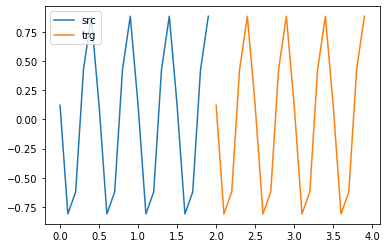

In [6]:
src, trg, freq_used_ = test_ds.__getitem__(0)
src_idx = np.arange(test_ds.n_src)
trg_idx = np.arange(test_ds.n_trg) + test_ds.n_src
f,ax = plt.subplots(1,1)
ax.plot(src_idx*test_ds.dt,src, label='src')
ax.plot(trg_idx*test_ds.dt,trg, label='trg')
ax.legend(loc=0)
print(freq_used_)

(array([3240., 3447., 3313.]),
 array([0.25, 0.75, 1.5 , 2.25]),
 <a list of 3 Patch objects>)

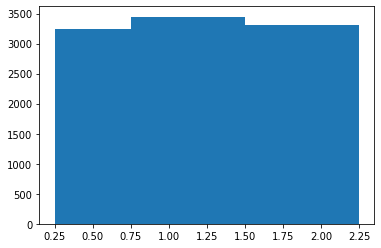

In [7]:
# see output statistics of the supposedly random frequencies presented.
n_samp = 10000
out_freq = np.zeros((n_samp))
for n in range(n_samp):
    _, _, out_freq_ = test_ds.__getitem__(0)
    out_freq[n] = out_freq_[0]
f,ax = plt.subplots(1,1)
ax.hist(out_freq,[0.25, 0.75, 1.5, 2.25])

Great! The random loader seems to work pretty well. Now let's make a seq2seq model and see how it learns this prediction problem

In [8]:
def train(model, iterator, optimizer, criterion, clip, teacher_forcing_ratio):

    model.train()

    epoch_loss = 0
    batch_loss = []

    enc_len = model.encoder.seq_len
    dec_len = model.decoder.seq_len
    n_ch = model.decoder.output_dim

    for i, (src,trg,_) in enumerate(iterator):
        if np.mod(i+1,1000) == 0:
            print(i,len(iterator))
#         src = batch[:,:enc_len,:]
#         trg = batch[:,enc_len:enc_len+dec_len,:n_ch] # only train to
        if dec_len == 1:
            trg = trg.unsqueeze(1)

        optimizer.zero_grad()
        output, _, _ = model(src, trg, teacher_forcing_ratio=teacher_forcing_ratio)

        #trg = [batch size, trg len, output dim]
        #output = [batch size, trg len, output dim]

        loss = criterion(output, trg)
        loss.backward()

        # clipping the gradient norm may not be very helpful...
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        
        # compute loss
        epoch_loss += loss.item()
        batch_loss.append(loss.item())

#         bar.update(10*i/10000)

#         if i > 10000:
#             break

    return epoch_loss, np.array(batch_loss)

In [9]:
def evaluate(model, iterator, criterion, plot_flag=False):

    model.eval()

    epoch_loss = 0
    batch_loss = []

    enc_len = model.encoder.seq_len
    dec_len = model.decoder.seq_len

    n_ch = model.decoder.output_dim # rename to *_dim?
    n_h_ch = model.encoder.hid_dim

    batch_size = iterator.batch_size

    with torch.no_grad():
#         widgets = [pb.Percentage(), progressbar.Bar()]
#         bar = pb.ProgressBar(widgets=widgets).start()
#         i = 0
        if plot_flag:
            src_ = torch.zeros(len(iterator),enc_len,n_ch)
            src_dx_ = torch.zeros(len(iterator),enc_len,n_ch)
            trg_ = torch.zeros(len(iterator),dec_len,n_ch)
            out_ = torch.zeros(len(iterator),dec_len,n_ch)
            enc_ = torch.zeros(len(iterator),enc_len,n_h_ch)
            dec_ = torch.zeros(len(iterator),dec_len,n_h_ch)

        for i, (src,trg,_) in enumerate(iterator):

            if np.mod(i+1,1000)==0:
                print(i,len(iterator))
            if dec_len == 1:
                trg = trg.unsqueeze(1)

            output, enc_state, dec_state = model(src, trg, teacher_forcing_ratio=0.) #turn off teacher forcing
            if plot_flag:
                src_[i,] = src[:,:,:n_ch]
                if src.shape[-1] > n_ch:
                    src_dx_[i,] = src[:,:,n_ch:]
                else:
                    src_dx_[i,] = 0. # works?
                trg_[i,] = trg
                out_[i,] = output
                enc_[i,] = enc_state
                dec_[i,] = dec_state

            #trg = [batch size, trg len]
            #output = [batch size, trg len, output dim]

            output_dim = output.shape[-1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            batch_loss.append(loss.item())

        plot_output = []
        if plot_flag:
            # print('num batch:\t{}'.format(num_batch))
            # print(src.size(),trg.size(),output.size())
            for k in range(len(src_)):
                plot_output.append((src_[k,],src_dx_[k,],trg_[k,],out_[k,],enc_[k,],dec_[k,]))

    # there may be a bug in the loss normalization here
    return epoch_loss, np.array(batch_loss), plot_output

In [10]:
# simple progressbar, not tied to the iterator
def print_progress_bar(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [11]:
from mpl_toolkits.mplot3d import Axes3D
def plot_current_model_output(model,dataset,file_name=None,figsize=(8,10),plot_hidden_states=False):
    # get a sample
    src,trg,_ = dataset.__getitem__(0)
    src = torch.tensor(src).unsqueeze(0)
    trg = torch.tensor(trg).unsqueeze(0)
    # produce an estimate
    out,enc,dec = model.forward(src,trg,teacher_forcing_ratio=0.0)
    out = out.detach().numpy()
    enc = enc.detach().numpy()
    dec = dec.detach().numpy()
    src_idx = np.arange(test_ds.n_src)
    trg_idx = np.arange(test_ds.n_trg) + test_ds.n_src
    # plot outputs
    n_ch = src.shape[-1]
    n_hid = enc.shape[-1]
    n_oc = np.min((2,n_ch))
    n_or = math.ceil(n_ch/n_oc)
    n_h = enc.shape[-1]
    n_hc = np.min((n_h,3))
    n_hr = math.ceil(n_h/n_hc)
#     f_out,ax = plt.subplots(n_r,n_c,figsize=(10,6*n_r),constrained_layout=True,squeeze=False)
    f_out = plt.figure(figsize=figsize,tight_layout=True,dpi=100)
    if plot_hidden_states:
        gs = gridspec.GridSpec(5+(n_hr-1),1,figure=f_out)
        gs_out = gridspec.GridSpecFromSubplotSpec(n_or,n_oc,subplot_spec=gs[0:3])
        gs_hid = gridspec.GridSpecFromSubplotSpec(n_hr,n_hc,subplot_spec=gs[3:])
    else:
        gs = gridspec.GridSpec(5+(n_hr-1),1,figure=f_out)
        gs_out = gridspec.GridSpecFromSubplotSpec(n_or,n_oc,subplot_spec=gs[:])
    # input/output
    for k in range(n_ch):
        ax = f.add_subplot(gs_out[k//n_oc,k%n_oc])
        ax.plot(src_idx,src[0,:,k],'k',label='src')
        ax.plot(trg_idx,trg[0,:,k],'k',label='trg')
        ax.plot(trg_idx,out[0,:,k],'ro--',label='out')
        ax.set_title('ch. {}'.format(k))
        if k == 0:
            ax.legend(loc=0)
    if plot_hidden_states:
        # hidden space
        hid_dim_pair_list = list(combinations(np.arange(n_h),2))
        n_hid_dim_pair = len(hid_dim_pair_list)
        for hd_idx in range(n_hid_dim_pair):
            r_idx = hd_idx//n_hc
            c_idx = hd_idx%n_hc
            hd1, hd2 = hid_dim_pair_list[hd_idx]
            h_ax = f.add_subplot(gs_hid[r_idx,c_idx])
            h_ax.plot(enc[0,:,hd1],enc[0,:,hd2],color='g',label='enc')
            h_ax.plot([enc[0,-1,hd1],dec[0,0,hd1]],[enc[0,-1,hd2],dec[0,0,hd2]],color='k')
            h_ax.plot(dec[0,:,hd1],dec[0,:,hd2],color='m',label='dec')
            h_ax.set_title('$h_{}$, $h_{}$'.format(hd1,hd2))
            if hd_idx == 0:
                h_ax.legend(loc=0)
    if file_name != None:
        f.savefig(file_name)
    return f_out

In [63]:
# freq = [1.2, 1.5, 1.8, 2.1]
freq = [3.5]
dt = 0.1
n_ch = 1
n_src = 20
n_trg = 100
test_ds = RandSinDataset(freq=freq,dt=dt,n_ch=n_ch,n_src=n_src,n_trg=n_trg) # max 5Hz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_units = 15
n_layers = 1
dropout = np.float32(0.0)
enc = Encoder.Encoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_src, dropout)
dec = Decoder.Decoder_GRU(test_ds.n_ch, n_units, n_layers, test_ds.n_trg, dropout)

model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
model.apply(Util.init_weights) # initialize the model each time.

print(f'The model has {Util.count_parameters(model):,} trainable parameters')

LOSS_OBJ = 'L2'
criterion = Training.ECOGLoss(objective=LOSS_OBJ)

l_rate = 0.001 # default
optimizer = optim.Adam(model.parameters(),lr=l_rate)

The model has 1,636 trainable parameters


In [67]:
# train the model over a few epochs, check that the loss is decreasing for both train, test sets.
n_epoch = 5000
batch_size=100
n_train = batch_size
n_test = batch_size

plot_step = 10

stop_thresh = 0.01
train_loss = []
test_loss = []
print_progress_bar(0, n_epoch, status='')
fig_save_dir = './switch_1freq_1ch_varyOutput/'
if not os.path.exists(fig_save_dir):
    os.makedirs(fig_save_dir)
# loop across output lengths and see the result
run_opt_loop = True
# for ep in range(n_epoch):
ep = 0
while run_opt_loop:
    if ep % plot_step == 0:
        # plot current prediction behavior
        fig_file_name = os.path.join(fig_save_dir,'ep{}.png'.format(ep))
        model_state_file_name = os.path.join(fig_save_dir,'ep{}.pt'.format(ep))
        f = plot_current_model_output(model,test_ds,file_name=fig_file_name)
        torch.save(model.state_dict(),model_state_file_name)
        plt.close(f)
    train_sampler = SequentialSampler(range(n_train))
    train_loader = DataLoader(test_ds,batch_size=batch_size,sampler=train_sampler)
    test_sampler = SequentialSampler(range(n_test))
    test_loader = DataLoader(test_ds,batch_size=batch_size,sampler=test_sampler)
    trl, _ = train(model, train_loader, optimizer, criterion, clip=np.float32(1.0), teacher_forcing_ratio=np.float32(0.0))
    tel, _, _ = evaluate(model, test_loader, criterion)
    train_loss.append(trl/batch_size) # normalize the 
    test_loss.append(tel/batch_size)
    # "are we there yet?"
    run_opt_loop = np.mean(test_loss[-10:]) > stop_thresh
    print_progress_bar(ep+1, n_epoch, status='({})\t{:0.3g}/{:0.3g}'.format(ep,train_loss[-1],test_loss[-1]))
    ep += 1

SystemError: <built-in method write of _io.BufferedWriter object at 0x1a290f8590> returned a result with an error set

<Figure size 800x1000 with 0 Axes>

Min Loss:
Training Data:	0.081\Test Data:	0.0996


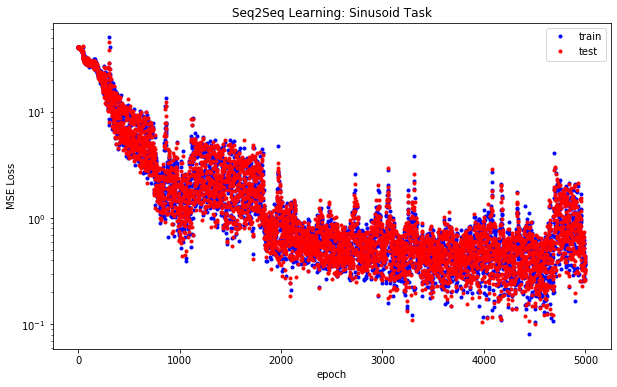

In [33]:
f,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(train_loss,'b.',label='train')
ax.plot(test_loss,'r.',label='test')
ax.set_yscale('log')
ax.legend(loc=0)
ax.set_xlabel('epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Seq2Seq Learning: Sinusoid Task')
print('Min Loss:\nTraining Data:\t{:05.3g}\Test Data:\t{:05.3g}'.format(np.min(train_loss),np.min(test_loss)))

It trains! It trains multiple attractors. Wow! Let's look at the eigenvalues of that transition matrix:

#### Everything below this is superfluous (at this point)

In [ ]:
# note: this will only work for a single layer, as-is.
def split_seq2seq_param_matrices(model_dict):
    ## encoder
    _,n_u_enc = model_dict['encoder.rnn.weight_hh_l0'].shape
    # i -> h
    W_ir_e = model_dict['encoder.rnn.weight_ih_l0'][:n_u_enc,]
    W_iz_e = model_dict['encoder.rnn.weight_ih_l0'][n_u_enc:2*n_u_enc,]
    W_in_e = model_dict['encoder.rnn.weight_ih_l0'][2*n_u_enc:3*n_u_enc,]
    b_ir_e = model_dict['encoder.rnn.bias_ih_l0'][:n_u_enc,]
    b_iz_e = model_dict['encoder.rnn.bias_ih_l0'][n_u_enc:2*n_u_enc,]
    b_in_e = model_dict['encoder.rnn.bias_ih_l0'][2*n_u_enc:3*n_u_enc,]
    # h -> h
    W_hr_e = model_dict['encoder.rnn.weight_hh_l0'][:n_u_enc,]
    W_hz_e = model_dict['encoder.rnn.weight_hh_l0'][n_u_enc:2*n_u_enc,]
    W_hn_e = model_dict['encoder.rnn.weight_hh_l0'][2*n_u_enc:3*n_u_enc,]
    b_hr_e = model_dict['encoder.rnn.bias_hh_l0'][:n_u_enc,]
    b_hz_e = model_dict['encoder.rnn.bias_hh_l0'][n_u_enc:2*n_u_enc,]
    b_hn_e = model_dict['encoder.rnn.bias_hh_l0'][2*n_u_enc:3*n_u_enc,]
    ## decoder
    _,n_u_dec = model_dict['encoder.rnn.weight_hh_l0'].shape
    # i -> h
    W_ir_d = model_dict['decoder.rnn.weight_ih_l0'][:n_u_dec,]
    W_iz_d = model_dict['decoder.rnn.weight_ih_l0'][n_u_dec:2*n_u_dec,]
    W_in_d = model_dict['decoder.rnn.weight_ih_l0'][2*n_u_dec:3*n_u_dec,]
    b_ir_d = model_dict['decoder.rnn.bias_ih_l0'][:n_u_dec,]
    b_iz_d = model_dict['decoder.rnn.bias_ih_l0'][n_u_dec:2*n_u_dec,]
    b_in_d = model_dict['decoder.rnn.bias_ih_l0'][2*n_u_dec:3*n_u_dec,]
    # h -> h
    W_hr_d = model_dict['decoder.rnn.weight_hh_l0'][:n_u_dec,]
    W_hz_d = model_dict['decoder.rnn.weight_hh_l0'][n_u_dec:2*n_u_dec,]
    W_hn_d = model_dict['decoder.rnn.weight_hh_l0'][2*n_u_dec:3*n_u_dec,]
    b_hr_d = model_dict['decoder.rnn.bias_hh_l0'][:n_u_dec,]
    b_hz_d = model_dict['decoder.rnn.bias_hh_l0'][n_u_dec:2*n_u_dec,]
    b_hn_d = model_dict['decoder.rnn.bias_hh_l0'][2*n_u_dec:3*n_u_dec,]
    # fc linear out
    W_fc_d = model_dict['decoder.fc_out.weight']
    b_fc_d = model_dict['decoder.fc_out.bias']
    ## collect into dict
    param_dict = {
        'encoder' : {
            # i -> h
            'Wir' : W_ir_e,
            'Wiz' : W_iz_e,
            'Win' : W_in_e,
            'bir' : b_ir_e,
            'biz' : b_iz_e,
            'bin' : b_in_e,
            # h -> h
            'Whr' : W_hr_e,
            'Whz' : W_hz_e,
            'Whn' : W_hn_e,
            'bhr' : b_hr_e,
            'bhz' : b_hz_e,
            'bhn' : b_hn_e
        },
        'decoder' : {
            # i -> h
            'Wir' : W_ir_d,
            'Wiz' : W_iz_d,
            'Win' : W_in_d,
            'bir' : b_ir_d,
            'biz' : b_iz_d,
            'bin' : b_in_d,
            # h -> h
            'Whr' : W_hr_d,
            'Whz' : W_hz_d,
            'Whn' : W_hn_d,
            'bhr' : b_hr_d,
            'bhz' : b_hz_d,
            'bhn' : b_hn_d,
            # h -> o
            'Wfc' : W_fc_d,
            'bfc' : b_fc_d
        }
    }
    return param_dict

In [ ]:
from matplotlib import gridspec
def plot_seq2seq_params(param_dict,cmap=plt.cm.seismic,figsize=(20,10)):
    ## plots a full schematic of all network parameter values for a seq2seq recurrent model.
    # if I can find a smart way of iterating through the parameterization, I'll have to implement that.
    # in the meantime, it's spaghetti dinner.
    
    # create figure, axes from gridspec
    f_params = plt.figure(constrained_layout=True,figsize=figsize)
    gs = gridspec.GridSpec(1,2)
    enc_gs = gs[0].subgridspec(4,10)
    dec_gs = gs[1].subgridspec(4,10)
    # define colormap
    max_val = np.concatenate([[param_dict[rnn][param].max().item() for param in param_dict[rnn].keys()] for rnn in param_dict.keys()]).max()
    min_val = np.concatenate([[param_dict[rnn][param].min().item() for param in param_dict[rnn].keys()] for rnn in param_dict.keys()]).min()
    im_norm = plt.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(cmap=cmap,norm=im_norm)
    # encoder parameters
    ax_Wir_enc = f_params.add_subplot(enc_gs[0,:4])
    ax_bir_enc = f_params.add_subplot(enc_gs[0,4])
    ax_Whr_enc = f_params.add_subplot(enc_gs[0,5:9])
    ax_bhr_enc = f_params.add_subplot(enc_gs[0,9])
    ax_Wiz_enc = f_params.add_subplot(enc_gs[1,:4])
    ax_biz_enc = f_params.add_subplot(enc_gs[1,4])
    ax_Whz_enc = f_params.add_subplot(enc_gs[1,5:9])
    ax_bhz_enc = f_params.add_subplot(enc_gs[1,9])
    ax_Win_enc = f_params.add_subplot(enc_gs[2,:4])
    ax_bin_enc = f_params.add_subplot(enc_gs[2,4])
    ax_Whn_enc = f_params.add_subplot(enc_gs[2,5:9])
    ax_bhn_enc = f_params.add_subplot(enc_gs[2,9])
    # decoder_parameters
    ax_Wir_dec = f_params.add_subplot(dec_gs[0,:4])
    ax_bir_dec = f_params.add_subplot(dec_gs[0,4])
    ax_Whr_dec = f_params.add_subplot(dec_gs[0,5:9])
    ax_bhr_dec = f_params.add_subplot(dec_gs[0,9])
    ax_Wiz_dec = f_params.add_subplot(dec_gs[1,:4])
    ax_biz_dec = f_params.add_subplot(dec_gs[1,4])
    ax_Whz_dec = f_params.add_subplot(dec_gs[1,5:9])
    ax_bhz_dec = f_params.add_subplot(dec_gs[1,9])
    ax_Win_dec = f_params.add_subplot(dec_gs[2,:4])
    ax_bin_dec = f_params.add_subplot(dec_gs[2,4])
    ax_Whn_dec = f_params.add_subplot(dec_gs[2,5:9])
    ax_bhn_dec = f_params.add_subplot(dec_gs[2,9])
    ax_Wfc_dec = f_params.add_subplot(dec_gs[3,:4])
    ax_bfc_dec = f_params.add_subplot(dec_gs[3,4])
    # colorbar
#     ax_cb = f_params.add_subplot(enc_gs[3,5:9])
#     ax_cb = ax_Whn_enc.append_axes("bottom", size="10%")#, pad=0.05)
    ax_cb = f_params.add_axes([0.52, 0.5, 0.01, 0.2])
    
    # plot parameter heatmaps
    # encoder
    ax_Wir_enc.imshow(param_dict['encoder']['Wir'],cmap=cmap,norm=im_norm)
    ax_Wir_enc.set_title('Encoder\n$W_{ir}$')
    ax_bir_enc.imshow(param_dict['encoder']['bir'][:,None],cmap=cmap,norm=im_norm)
    ax_bir_enc.set_title('$b_{ir}$')
    ax_Whr_enc.imshow(param_dict['encoder']['Whr'],cmap=cmap,norm=im_norm)
    ax_Whr_enc.set_title('$W_{hr}$')
    ax_bhr_enc.imshow(param_dict['encoder']['bhr'][:,None],cmap=cmap,norm=im_norm)
    ax_bhr_enc.set_title('$b_{hr}$')
    ax_Wiz_enc.imshow(param_dict['encoder']['Wiz'],cmap=cmap,norm=im_norm)
    ax_Wiz_enc.set_title('$W_{iz}$')
    ax_biz_enc.imshow(param_dict['encoder']['biz'][:,None],cmap=cmap,norm=im_norm)
    ax_biz_enc.set_title('$b_{iz}$')
    ax_Whz_enc.imshow(param_dict['encoder']['Whz'],cmap=cmap,norm=im_norm)
    ax_Whz_enc.set_title('$W_{hz}$')
    ax_bhz_enc.imshow(param_dict['encoder']['bhz'][:,None],cmap=cmap,norm=im_norm)
    ax_bhz_enc.set_title('$b_{hz}$')
    ax_Win_enc.imshow(param_dict['encoder']['Win'],cmap=cmap,norm=im_norm)
    ax_Win_enc.set_title('$W_{in}$')
    ax_bin_enc.imshow(param_dict['encoder']['bin'][:,None],cmap=cmap,norm=im_norm)
    ax_bin_enc.set_title('$b_{in}$')
    ax_Whn_enc.imshow(param_dict['encoder']['Whn'],cmap=cmap,norm=im_norm)
    ax_Whn_enc.set_title('$W_{hn}$')
    ax_bhn_enc.imshow(param_dict['encoder']['bhn'][:,None],cmap=cmap,norm=im_norm)
    ax_bhn_enc.set_title('$b_{hn}$')
    # decoder
    ax_Wir_dec.imshow(param_dict['decoder']['Wir'],cmap=cmap,norm=im_norm)
    ax_Wir_dec.set_title('Decoder\n$W_{ir}$')
    ax_bir_dec.imshow(param_dict['decoder']['bir'][:,None],cmap=cmap,norm=im_norm)
    ax_bir_dec.set_title('$b_{ir}$')
    ax_Whr_dec.imshow(param_dict['decoder']['Whr'],cmap=cmap,norm=im_norm)
    ax_Whr_dec.set_title('$W_{hr}$')
    ax_bhr_dec.imshow(param_dict['decoder']['bhr'][:,None],cmap=cmap,norm=im_norm)
    ax_bhr_dec.set_title('$b_{hr}$')
    ax_Wiz_dec.imshow(param_dict['decoder']['Wiz'],cmap=cmap,norm=im_norm)
    ax_Wiz_dec.set_title('$W_{iz}$')
    ax_biz_dec.imshow(param_dict['decoder']['biz'][:,None],cmap=cmap,norm=im_norm)
    ax_biz_dec.set_title('$b_{iz}$')
    ax_Whz_dec.imshow(param_dict['decoder']['Whz'],cmap=cmap,norm=im_norm)
    ax_Whz_dec.set_title('$W_{hz}$')
    ax_bhz_dec.imshow(param_dict['decoder']['bhz'][:,None],cmap=cmap,norm=im_norm)
    ax_bhz_dec.set_title('$b_{hz}$')
    ax_Win_dec.imshow(param_dict['decoder']['Win'],cmap=cmap,norm=im_norm)
    ax_Win_dec.set_title('$W_{in}$')
    ax_bin_dec.imshow(param_dict['decoder']['bin'][:,None],cmap=cmap,norm=im_norm)
    ax_bin_dec.set_title('$b_{in}$')
    ax_Whn_dec.imshow(param_dict['decoder']['Whn'],cmap=cmap,norm=im_norm)
    ax_Whn_dec.set_title('$W_{hn}$')
    ax_bhn_dec.imshow(param_dict['decoder']['bhn'][:,None],cmap=cmap,norm=im_norm)
    ax_bhn_dec.set_title('$b_{hn}$')
    ax_Wfc_dec.imshow(param_dict['decoder']['Wfc'],cmap=cmap,norm=im_norm)
    ax_Wfc_dec.set_title('$W_{fc}$')
    ax_bfc_dec.imshow(param_dict['decoder']['bfc'][:,None])
    ax_bfc_dec.set_title('$b_{fc}$')
    
    # colorbar
    cb = plt.colorbar(scalar_map,cax=ax_cb,orientation='vertical')
    cb.set_label('amplitude')
    
    # adjust axes
    [ax.axis('off') for ax in f_params.axes[:-1]]
    
    return f_params

In [ ]:
def plot_matrix(X,name='',cmap=plt.cm.seismic,n_ev=3):
    
    # compute SVD
    u,s,v = sp.linalg.svd(X)
    ev = s**2
    nsev = np.cumsum(ev)/ev.sum()
    
    # make figure, axes, mappables
    f_mat,ax = plt.subplots(2,2,figsize=(10,8),tight_layout=True)
    max_val = X.max().item()
    min_val = X.min().item()
    im_norm = plt.Normalize(vmin=min_val, vmax=max_val)
    scalar_map = plt.cm.ScalarMappable(cmap=cmap,norm=im_norm)
    left_cm_f = plt.cm.Greens
    right_cm_f = plt.cm.Purples
    left_cm = left_cm_f(np.linspace(1,0.4,n_ev))
    right_cm = right_cm_f(np.linspace(1,0.4,n_ev))
    
    # image itself
    ax[0,0].imshow(X,cmap=cmap,norm=im_norm)
    ax[0,0].set_title('{} $= U\Sigma V^T$'.format(name))
    plt.colorbar(scalar_map,ax=ax[0,0])
    
    # singular values, cumsum
    ax[0,1].plot(ev,color='tab:blue')
    ax[0,1].set_ylabel('eigenvalue',color='tab:blue')
    ax12 = ax[0,1].twinx()
    ax12.plot(nsev,color='tab:red')
    ax12.axvline(n_ev-1,color='gray')
    ax12.axhline(nsev[n_ev-1],color='gray')
    ax12.text(n_ev-1,nsev[n_ev-1],'(num_ev = {}, {:05.3f})'.format(n_ev,nsev[n_ev-1]),verticalalignment='top')
    ax12.set_ylim([-0.05,1.05])
    ax12.set_ylabel('norm. e.v. sum',color='tab:red')
    ax[0,1].set_title('$\sigma^2$ spectrum')
    
    # left, right eigenvectors (u)
    offset_y = np.arange(n_ev)*0.3
    for k in range(n_ev):
        ax[1,0].plot(offset_y[k] + u[:,k],color=left_cm[k])
        ax[1,1].plot(offset_y[k] + v[:,k],color=right_cm[k])
    ax[1,0].set_title('$U$'.format(n_ev-1))
    ax[1,0].set_yticks(ticks=offset_y)
    ax[1,0].set_yticklabels(labels=range(n_ev))
    ax[1,1].set_title('$V$'.format(n_ev-1))
    ax[1,1].set_yticks(ticks=offset_y)
    ax[1,1].set_yticklabels(labels=range(n_ev))
    
    return f_mat,ax

In [ ]:
param_dict = split_seq2seq_param_matrices(model.state_dict())

In [ ]:
mat_name = ['Whr', 'Whz', 'Whn']
f,ax = plt.subplots(1,2,figsize=(10,4),dpi=100)
for mat_ in mat_name:
    eX = param_dict['encoder'][mat_]
    d,v = sp.linalg.eig(eX-np.eye(eX.shape[0]))
    u,s,vv = sp.linalg.svd(eX-np.eye(eX.shape[0]))
    ax[0].scatter(np.real(d),np.imag(d),alpha=0.5,label=mat_)
    dX = param_dict['decoder'][mat_]
    d,v = sp.linalg.eig(dX-np.eye(dX.shape[0]))
    u,s,vv = sp.linalg.svd(eX-np.eye(eX.shape[0]))
    ax[1].scatter(np.real(d),np.imag(d),alpha=0.5,label=mat_)
ax[0].set_title('Encoder')
ax[0].legend(loc=0)
ax[1].set_title('Decoder')
ax[1].legend(loc=0)

In [ ]:
mat_name = ['Whr', 'Whz', 'Whn']
f,ax = plt.subplots(1,2,figsize=(10,4),dpi=100)
for mat_ in mat_name:
    eX = param_dict['encoder'][mat_]
    eX_symm = (eX + eX.T)/2
    eX_asym = (eX - eX.T)/2
    d_symm,_ = sp.linalg.eig(eX_symm)
    d_asym,_ = sp.linalg.eig(eX_asym)
    ax[0].scatter(np.real(d_symm),np.imag(d_symm),alpha=0.5,label='{} symm.'.format(mat_))
    ax[0].scatter(np.real(d_asym),np.imag(d_asym),alpha=0.5,label='{} asym.'.format(mat_))
    dX = param_dict['decoder'][mat_]
    dX_symm = (dX + dX.T)/2
    dX_asym = (dX - dX.T)/2
    d_symm,_ = sp.linalg.eig(eX_symm)
    d_asym,_ = sp.linalg.eig(eX_asym)
    ax[1].scatter(np.real(d_symm),np.imag(d_symm),alpha=0.5,label='{} symm.'.format(mat_))
    ax[1].scatter(np.real(d_asym),np.imag(d_asym),alpha=0.5,label='{} asym.'.format(mat_))
ax[0].set_title('Encoder')
ax[0].legend(loc=0)
ax[1].set_title('Decoder')
ax[1].legend(loc=0)

### gate dynamics: what's happening in the $r$, $z$ and $\bar{h}$ values?

In [ ]:
def enc_cell_signals(model,hidden,x):
    None

def dec_cell_signals(model,hidden):
    None

In [ ]:
ep_file_list = ['ep100.pt','ep1050.pt','ep6500.pt']
mat_name = ['Whr', 'Whz', 'Whn']
f,ax = plt.subplots(2,len(mat_name),figsize=(12,8),dpi=100,sharex=True,sharey=True)
for ep_file in ep_file_list:
    with open(os.path.join('slow_down_be_simple',ep_file),'rb') as f:
        model_dict = torch.load(f)
    param_dict = split_seq2seq_param_matrices(model_dict)
    for m_idx, mat_ in enumerate(mat_name):
#         eX = param_dict['encoder'][mat_]
#         eX_symm = (eX + eX.T)/2
#         eX_asym = (eX - eX.T)/2
#         d_symm,_ = sp.linalg.eig(eX_symm)
#         d_asym,_ = sp.linalg.eig(eX_asym)
#         ax[0].scatter(np.real(d_symm),np.imag(d_symm),alpha=0.5,label='{} symm.'.format(mat_))
#         ax[0].scatter(np.real(d_asym),np.imag(d_asym),alpha=0.5,label='{} asym.'.format(mat_))
#         dX = param_dict['decoder'][mat_]
#         dX_symm = (dX + dX.T)/2
#         dX_asym = (dX - dX.T)/2
#         d_symm,_ = sp.linalg.eig(eX_symm)
#         d_asym,_ = sp.linalg.eig(eX_asym)
#         ax[1].scatter(np.real(d_symm),np.imag(d_symm),alpha=0.5,label='{} symm.'.format(mat_))
#         ax[1].scatter(np.real(d_asym),np.imag(d_asym),alpha=0.5,label='{} asym.'.format(mat_))
        # encoder e.val
        eX = param_dict['encoder'][mat_]
        d,v = sp.linalg.eig(eX-np.eye(eX.shape[0]))
        u,s,vv = sp.linalg.svd(eX-np.eye(eX.shape[0]))
        ax[0,m_idx].scatter(np.real(d),np.imag(d),alpha=0.5,label=ep_file[2:-3])
        # decoder e.val
        dX = param_dict['decoder'][mat_]
        d,v = sp.linalg.eig(dX-np.eye(dX.shape[0]))
        u,s,vv = sp.linalg.svd(eX-np.eye(eX.shape[0]))
        ax[1,m_idx].scatter(np.real(d),np.imag(d),alpha=0.5,label=ep_file[2:-3])
        ax[0,m_idx].set_title('Encoder {}'.format(mat_))
        ax[0,m_idx].legend(loc=0)
        ax[1,m_idx].set_title('Decoder {}'.format(mat_))
        ax[1,m_idx].legend(loc=0)
ax = ax.reshape(-1)
[ax_.axhline(0,alpha=0.2) for ax_ in ax]
[ax_.axvline(0,alpha=0.2) for ax_ in ax]